In [1]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from facenet_pytorch import InceptionResnetV1, MTCNN, extract_face
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from IPython.display import clear_output
from deepface import DeepFace
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist
import shutil

mtcnn = MTCNN()

In [2]:
paths = os.listdir('data')
paths = [os.path.join('data', path) for path in paths]

## Extract faces
This function get an image path and extract all the faces from the image

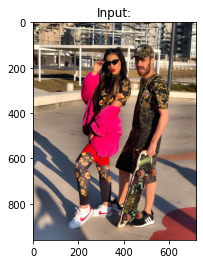

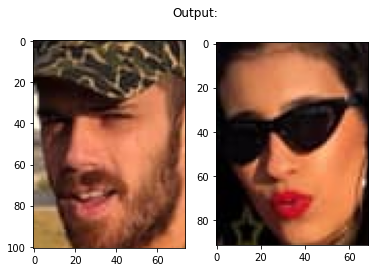

In [3]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def extract_faces(image_path, area_t=20*20, prob_t=0.2):
    image = read_img(image_path)
    boxes, probs = mtcnn.detect(image)
    
    faces = []
    
    for (x_start, y_start, x_end, y_end), prob in zip(boxes, probs):
            area = (x_end - x_start) * (y_end - y_start)
            if prob > 0.9 and area > (50 * 50):
                try:
                    face = image[int(y_start): int(y_end), int(x_start): int(x_end)]
                    faces.append(face)
                except Exception:
                    pass
    return faces

rand_img = paths[np.random.randint(0,len(paths))]

plt.title('Input:')
plt.imshow(read_img(rand_img))
plt.show()

faces = extract_faces(rand_img)

if len(faces) > 1:
    fig, axs = plt.subplots(1, len(faces))

    plt.suptitle('Output:')
    for i, face in enumerate(faces):
        axs[i].imshow(face)
    plt.show()
else:
    plt.title('Output:')
    plt.imshow(read_img(rand_img))
    plt.show()

## Build dataset

In [4]:
images, indices = [], []

folder_path = 'result/faces'

if os.path.exists(folder_path):    
    shutil.rmtree(folder_path)

os.makedirs(folder_path)

for i, img_path in enumerate(paths):
    faces = extract_faces(img_path)
    for face_idx, face in enumerate(faces):
        cv2.imwrite(f'{folder_path}/{i}_{face_idx}.jpg', cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    print(f'{len(faces)} faces saved in image {i}.')

5 faces saved in image 0.
1 faces saved in image 1.
1 faces saved in image 2.
2 faces saved in image 3.
2 faces saved in image 4.
1 faces saved in image 5.
2 faces saved in image 6.
3 faces saved in image 7.
1 faces saved in image 8.
6 faces saved in image 9.
2 faces saved in image 10.
3 faces saved in image 11.
2 faces saved in image 12.
1 faces saved in image 13.
2 faces saved in image 14.
1 faces saved in image 15.
1 faces saved in image 16.
2 faces saved in image 17.
1 faces saved in image 18.
2 faces saved in image 19.
2 faces saved in image 20.
2 faces saved in image 21.
2 faces saved in image 22.
1 faces saved in image 23.
2 faces saved in image 24.
1 faces saved in image 25.
2 faces saved in image 26.
6 faces saved in image 27.


## Embedding

In [5]:
models = [
  "VGG-Face", 
  "Facenet", 
  "Facenet512", 
  "OpenFace", 
  "DeepFace", 
  "DeepID", 
  "ArcFace", 
  "Dlib", 
  "SFace",
  "GhostFaceNet",
]

folder_path = 'result/embedding'
if os.path.exists(folder_path):   
    shutil.rmtree(folder_path)

os.makedirs(folder_path)

def embedding(img, model='Facenet'):
    embedding_objs = DeepFace.represent(img_path = img, model_name=model, enforce_detection=False)
    assert len(embedding_objs) == 1
    return embedding_objs[0]['embedding']

embeddings = []

for img in tqdm(os.listdir('result/faces')):
    img_name = img[:-4]
    img = read_img(os.path.join('result/faces', img))
    embed = embedding(img, model=models[2])
    np.save(f'{folder_path}/{img_name}.npy',embed)

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:10<00:00,  5.68it/s]


## Sanity check

In [6]:
paths = os.listdir('result/faces')
paths = [path[:-4] for path in paths]

images = []
embeddings = []

for path in tqdm(paths):
    image = read_img(f'result/faces/{path}.jpg')
    embedding = np.load(f'result/embedding/{path}.npy')
    
    images.append(image)
    embeddings.append(embedding)
    
embeddings = np.vstack(embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 363.28it/s]


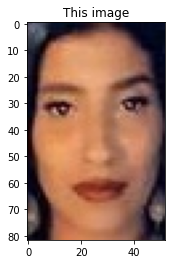

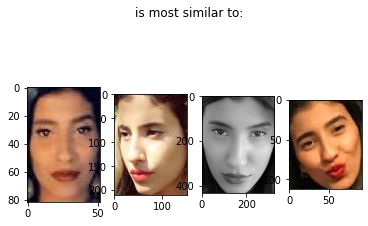

In [8]:
def cosine_similarity_table(matrix):
    norm = np.linalg.norm(matrix, axis=1, keepdims=True)
    normalized_matrix = matrix / norm
    similarity_matrix = np.dot(normalized_matrix, normalized_matrix.T)
    return similarity_matrix

def top_k_indices(matrix, row_index, k=5):
    row = matrix[row_index]
    sorted_indices = np.argsort(row)[-k:][::-1]
    return sorted_indices

similarity_table = cosine_similarity_table(embeddings)

k=4

i = np.random.randint(0, len(images))
top = top_k_indices(similarity_table, i, k=k)

plt.title('This image')
plt.imshow(images[i])
plt.show()

fig, axs = plt.subplots(1, k)
plt.suptitle('is most similar to:')
for i in range(k):
    axs[i].imshow(images[top[i]])
plt.show()